<a href="https://colab.research.google.com/github/nolpen6/MushroomInsight_ML/blob/main/notebooks/01_mushroom_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom Classification: Full Analysis & Modeling

This notebook is part of a group project by **Nolwenn Montillot**, **Hannah Zilesch**, and **Emma Lou Villaret**, where we build an end-to-end machine learning pipeline to classify mushrooms as *edible* or *poisonous* based solely on observable physical traits.

The dataset comes from the UCI Machine Learning Repository and includes **8,124 mushrooms**, each described by **22 categorical features** (odor, cap color, gill size, habitat, etc.). The goal isn’t just to hit high accuracy — that part is actually easy — but to **understand what features matter biologically**, evaluate **how each model behaves**, and test **hypotheses** about which traits predict toxicity.

## Notebook / Script Structure

1. Data loading & quick overview
2. Data dictionary & hypotheses
3. Exploratory Data Analysis (EDA)
4. Feature–target association (Chi-square, Mutual Information)
5. Data cleaning & preprocessing (one-hot, scaling, split)
6. Baseline model (Dummy)
7. Logistic Regression (linear)
8. Polynomial Logistic Regression (non-linear)
9. Decision Tree
10. Random Forest
11. K-Nearest Neighbors (KNN)
12. Model comparison summary
13. Error analysis (Random Forest misclassifications)
14. Final conclusions & limitations

# 1. Imports and Configuration

This section imports all necessary libraries for analysis and modeling.

### Libraries Used:
- **NumPy and Pandas**: Data manipulation and analysis
- **Matplotlib and Seaborn**: Data visualization
- **Scikit-learn**: Machine learning tools (models, metrics, preprocessing)

In [41]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 5)

# ML tools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay
)

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [42]:
# For clean warnings
import warnings
warnings.filterwarnings("ignore")

# Small helper to make nice barplots
def plot_bar(series, title, xlabel, ylabel="Score"):
    sns.barplot(x=series.values, y=series.index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# 2. Data Loading & Inspection

The Mushroom dataset contains 22 categorical features describing each mushroom’s physical traits:
- cap shape, cap color, cap surface  
- gill attachment, gill size, gill color  
- stalk shape, stalk surface, stalk color  
- odor  
- spore-print-color  
- ring number & ring type  
- habitat  
- population  
- and more.

The target variable `"poisonous"` is encoded as:
- `'e'` — edible  
- `'p'` — poisonous  

We convert these later into `0` (edible) and `1` (poisonous).

In [43]:
import pandas as pd
url = "https://archive.ics.uci.edu/static/public/73/data.csv"
df = pd.read_csv(url)
df.columns

Index(['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat', 'poisonous'],
      dtype='object')

In [44]:
print("Shape of raw dataset:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Shape of raw dataset: (8124, 23)

First 5 rows:
  cap-shape cap-surface cap-color bruises odor gill-attachment gill-spacing  \
0         x           s         n       t    p               f            c   
1         x           s         y       t    a               f            c   
2         b           s         w       t    l               f            c   
3         x           y         w       t    p               f            c   
4         x           s         g       f    n               f            w   

  gill-size gill-color stalk-shape  ... stalk-color-above-ring  \
0         n          k           e  ...                      w   
1         b          k           e  ...                      w   
2         b          n           e  ...                      w   
3         n          n           e  ...                      w   
4         b          k           t  ...                      w   

  stalk-color-below-ring veil-type veil-color ring-number ring-type  \
0        

In [45]:
print("\nInfo:")
print(df.info())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below

In [46]:
# Target variable quick look
print("\nTarget value counts (raw):")
print(df["poisonous"].value_counts())
print("\nTarget proportions:")
print(df["poisonous"].value_counts(normalize=True))


Target value counts (raw):
poisonous
e    4208
p    3916
Name: count, dtype: int64

Target proportions:
poisonous
e    0.517971
p    0.482029
Name: proportion, dtype: float64


In [47]:
# Absolute distribution (number of mushrooms per class)
df["poisonous"].value_counts()

# Relative distribution (proportions)
df["poisonous"].value_counts(normalize=True)

,proportion
poisonous,
e,0.517971
p,0.482029


# 3. Data Dictionary & Feature Glossary

A quick glossary of the features helps understand which characteristics might actually matter biologically.

### ► Odor  
Probably the most biologically meaningful feature. Categories include:  
`almond`, `anise`, `creosote`, `fishy`, `foul`, `musty`, `none`, `pungent`, `spicy`.

Several toxic species have very distinctive unpleasant smells.

### ► Gill attributes  
Gill size, spacing, attachment, and color all influence mushroom taxonomy.  
Many toxic mushrooms have specific combinations of gill size + color.

### ► Spore-print-color  
This is a classic mushroom identification method (used by field experts).  
Colors like `white`, `brown`, `green`, `black`, `buff`, etc.

### ► Stalk characteristics  
Shape, color, root type, texture above/below the ring.  
We will later discover that `stalk-root` becomes surprisingly predictive.

### ► Habitat & Population  
Where the mushroom grows (woods, urban, meadows, etc.)  
This might correlate with toxicity depending on species distribution.

This feature dictionary sets the stage for our **hypothesis-driven analysis** coming next.

# 4. Research Hypotheses

To make this project feel like real research,  
we define several hypotheses before looking at the models:

**H1 — Odor is the strongest predictor of toxicity.**  
Rationale: Toxic mushrooms often have strong, distinct smells.

**H2 — Spore print color is highly predictive.**  
Rationale: In mushroom taxonomy, spore print color is a key differentiator between poisonous genera.

**H3 — Habitat and bruising matter, but less strongly.**  
Rationale: These environmental features feel moderately useful but probably not extremely strong predictors.

We will test these using:
- EDA (visual)
- Chi-square tests
- Mutual information scores
- Model behavior (feature importance & errors)

# 5. Exploratory Data Analysis (EDA)

Exploratory data analysis is a fundamental step that allows us to:
1. **Understand data structure**: distributions, missing values, variable types
2. **Identify discriminative features**: which features allow us to distinguish edible from poisonous mushrooms?
3. **Detect patterns**: relationships between variables, correlations, anomalies
4. **Guide preprocessing**: decisions on missing value handling, encoding, etc.

In this section, we explore:
- The target variable distribution (`poisonous`)
- Relationships between key features and toxicity
- The most predictive features

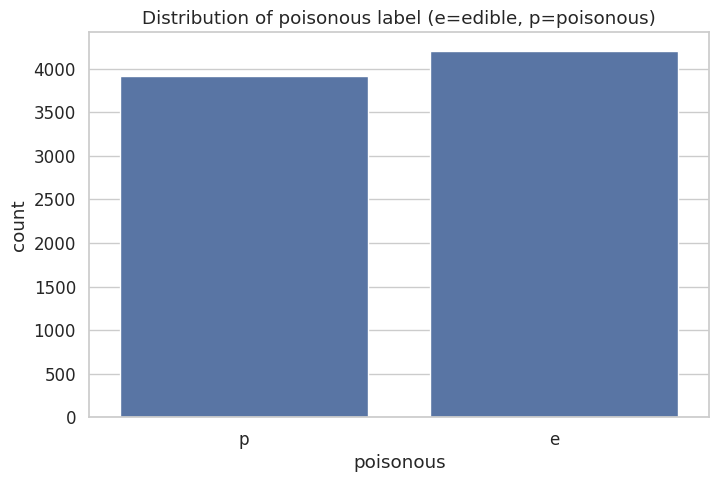

In [48]:
# Target distribution bar plot
sns.countplot(x="poisonous", data=df)
plt.title("Distribution of poisonous label (e=edible, p=poisonous)")
plt.show()

In [49]:
print("\nTarget proportions:")
print(df["poisonous"].value_counts(normalize=True))


Target proportions:
poisonous
e    0.517971
p    0.482029
Name: proportion, dtype: float64


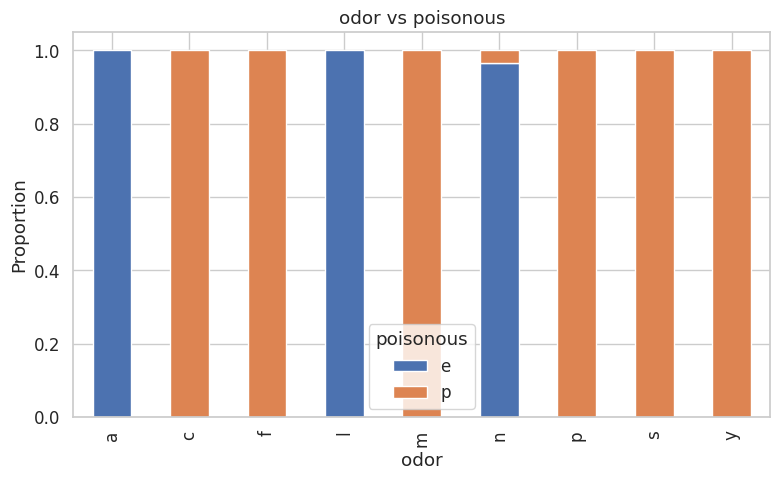

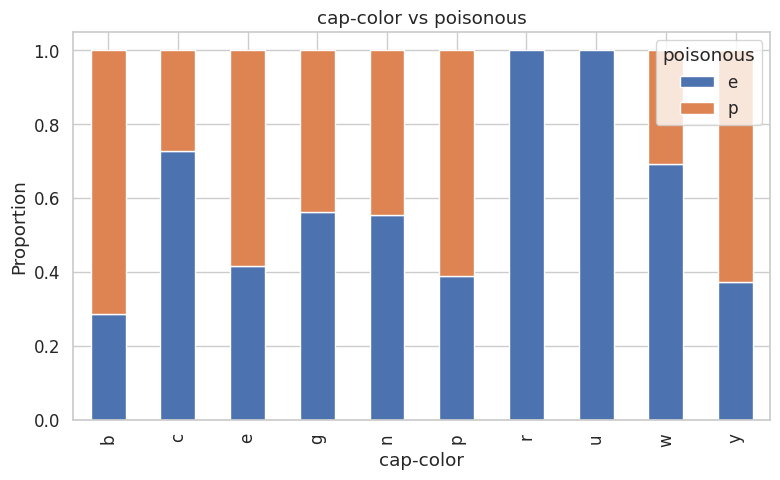

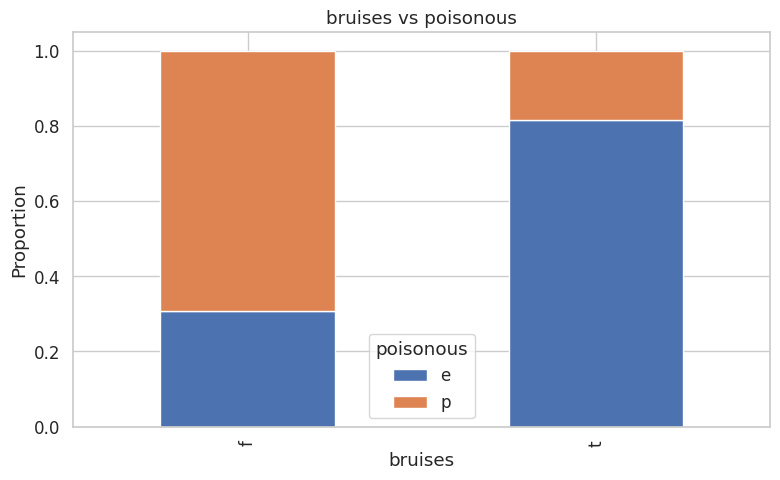

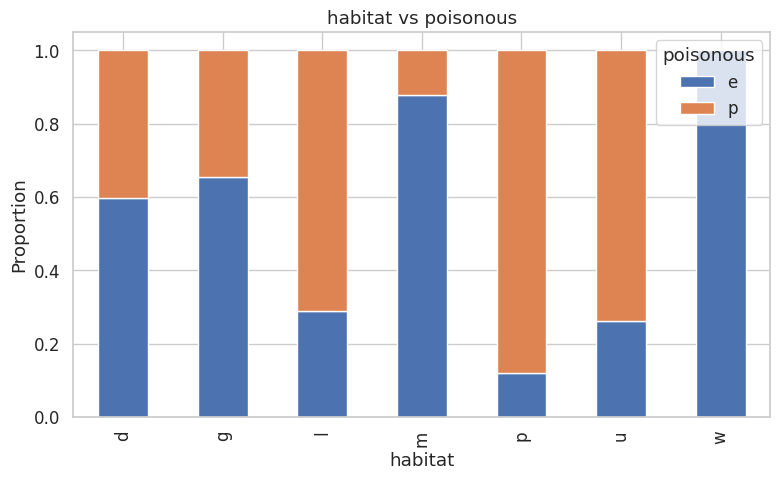

In [50]:
# Helper: stacked barplots of feature vs target
def plot_cat_feature(feature):
    ct = pd.crosstab(df[feature], df["poisonous"], normalize="index")
    ct.plot(kind="bar", stacked=True)
    plt.title(f"{feature} vs poisonous")
    plt.ylabel("Proportion")
    plt.legend(title="poisonous")
    plt.tight_layout()
    plt.show()

for feat in ["odor", "cap-color", "bruises", "habitat"]:
    plot_cat_feature(feat)

### **Summary of EDA Observations**

A few things become obvious very quickly:

- **Odor practically gives away the answer.**  
  Odors like *foul*, *fishy*, *pungent*, and *creosote* correspond almost exclusively to poisonous mushrooms.  
  This already hints that H1 (odor is the strongest predictor) is probably true.

- **Bruising shows the opposite pattern.**  
  Edible mushrooms often bruise, while poisonous ones are more rigid and do not — a surprisingly reliable signal.

- **Habitat has signal, but it’s messy.**  
  Some habitats are dominated by edible species, but the relationship isn’t perfectly clean.

- **Cap color is visually noisy.**  
  There’s no strong separation, meaning this feature will likely have low predictive value.

These patterns not only justify our hypotheses but also explain why the ML models later achieve such extreme accuracy:  
**the classes are almost perfectly separated by a couple of categorical features.**

# 6. Association Strength: Chi-Square & Mutual Information

Now we quantify how strongly each feature is associated with toxicity.

We:
1. One-hot encode all features (without touching the target).
2. Run chi-square tests for independence.
3. Compute mutual information scores.

This gives us feature rankings that we can compare to our hypotheses.

In [51]:
# Work on a copy so we don't break df later
df_clean = df.copy()

# Replace "?" with NaN for proper missing value handling later
df_clean = df_clean.replace("?", pd.NA)

In [52]:
# Target (still string labels 'e'/'p' at this point)
y_raw = df_clean["poisonous"]

# Features (categorical)
X_cat = df_clean.drop("poisonous", axis=1)

# One-hot encode all categorical features
X_encoded_full = pd.get_dummies(X_cat, drop_first=True)

print("\nEncoded feature matrix shape:", X_encoded_full.shape)


Encoded feature matrix shape: (8124, 94)


In [53]:
from sklearn.feature_selection import chi2

# Convert target to numeric 0/1 for stats
y_num = y_raw.map({"e": 0, "p": 1})

# Chi-square
chi2_scores, p_values = chi2(X_encoded_full, y_num)
chi2_df = pd.DataFrame(
    {"feature": X_encoded_full.columns, "chi2": chi2_scores, "p_value": p_values}
).sort_values("chi2", ascending=False)

top_chi2 = chi2_df.head(15).set_index("feature")["chi2"]
print("\nTop 15 features by Chi-square:")
print(top_chi2)


Top 15 features by Chi-square:
feature
odor_n                        2836.187954
odor_f                        2321.062308
stalk-surface-above-ring_k    1986.408494
stalk-surface-below-ring_k    1914.371389
gill-size_n                   1636.606833
spore-print-color_h           1560.187561
ring-type_l                   1392.637385
ring-type_p                   1213.995219
bruises_t                     1194.277352
spore-print-color_n           1068.640377
spore-print-color_k            984.538675
gill-spacing_w                 826.795274
population_v                   804.096921
spore-print-color_w            732.621008
habitat_p                      729.776436
Name: chi2, dtype: float64


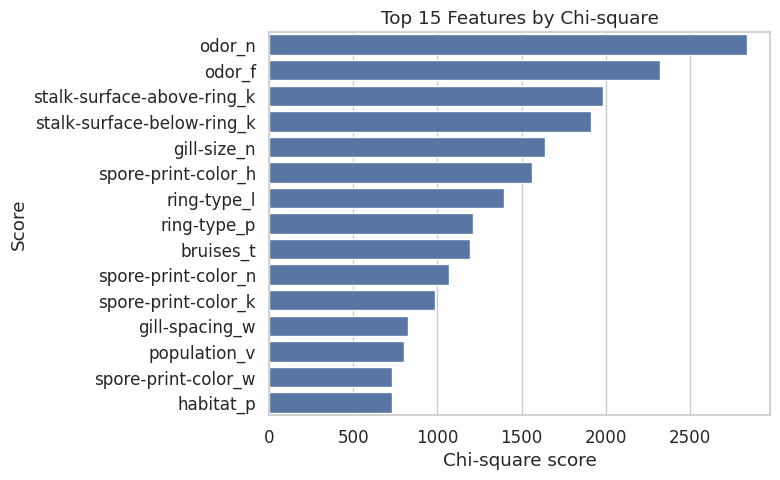

In [54]:
plot_bar(top_chi2, "Top 15 Features by Chi-square", "Chi-square score")

In [55]:
from sklearn.feature_selection import mutual_info_classif

# Mutual Information
mi_scores = mutual_info_classif(X_encoded_full, y_num, discrete_features=True)
mi_df = pd.DataFrame(
    {"feature": X_encoded_full.columns, "mi": mi_scores}
).sort_values("mi", ascending=False)

top_mi = mi_df.head(15).set_index("feature")["mi"]
print("\nTop 15 features by Mutual Information:")
print(top_mi)


Top 15 features by Mutual Information:
feature
odor_n                        0.366521
odor_f                        0.247570
stalk-surface-above-ring_k    0.197151
stalk-surface-below-ring_k    0.187538
gill-size_n                   0.159531
ring-type_p                   0.154365
spore-print-color_h           0.144053
bruises_t                     0.133347
ring-type_l                   0.132870
stalk-surface-above-ring_s    0.127236
population_v                  0.101968
spore-print-color_n           0.096584
stalk-surface-below-ring_s    0.093628
spore-print-color_k           0.087366
gill-spacing_w                0.069927
Name: mi, dtype: float64


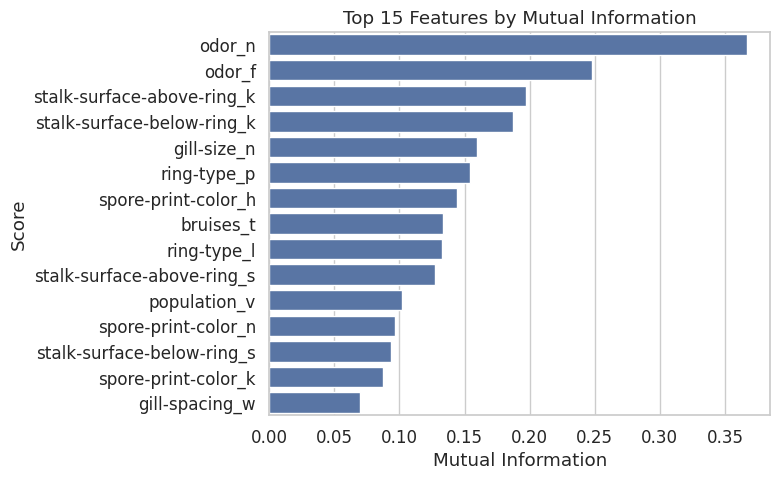

In [56]:
plot_bar(top_mi, "Top 15 Features by Mutual Information", "Mutual Information")

**Association analysis takeaways:**

- Odor-related dummy variables absolutely dominate both Chi-square and MI rankings.
- Spore-print-color dummies rank very high as well.
- Some stalk-root and gill-color variants also show up in the top list.
- Habitat and bruises appear, but not at the very top.

So:
- H1 (odor strongest predictor) → strongly supported.
- H2 (spore-print-color highly predictive) → supported.
- H3 (habitat + bruises secondary) → supported; they show up but not as top-1 stars.

In [57]:
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    """
    Compute Cramér's V statistic for categorical-categorical association.
    """
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Bias correction (useful when table is not huge)
    phi2_corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    r_corr = r - ((r - 1)**2) / (n - 1)
    k_corr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

In [58]:
cat_cols = [
    "odor",
    "spore-print-color",
    "gill-color",
    "cap-color",
    "bruises",
    "habitat",
    "stalk-root",
    "gill-size",
    "population",
    "ring-type",
]

In [59]:
# Compute Cramér's V matrix
n_features = len(cat_cols)
cramers_matrix = np.zeros((n_features, n_features))

for i, col_i in enumerate(cat_cols):
    for j, col_j in enumerate(cat_cols):
        if i == j:
            cramers_matrix[i, j] = 1.0
        elif i < j:
            table = pd.crosstab(df_clean[col_i], df_clean[col_j])
            cv = cramers_v(table.values)
            cramers_matrix[i, j] = cv
            cramers_matrix[j, i] = cv

cramers_df = pd.DataFrame(cramers_matrix, index=cat_cols, columns=cat_cols)

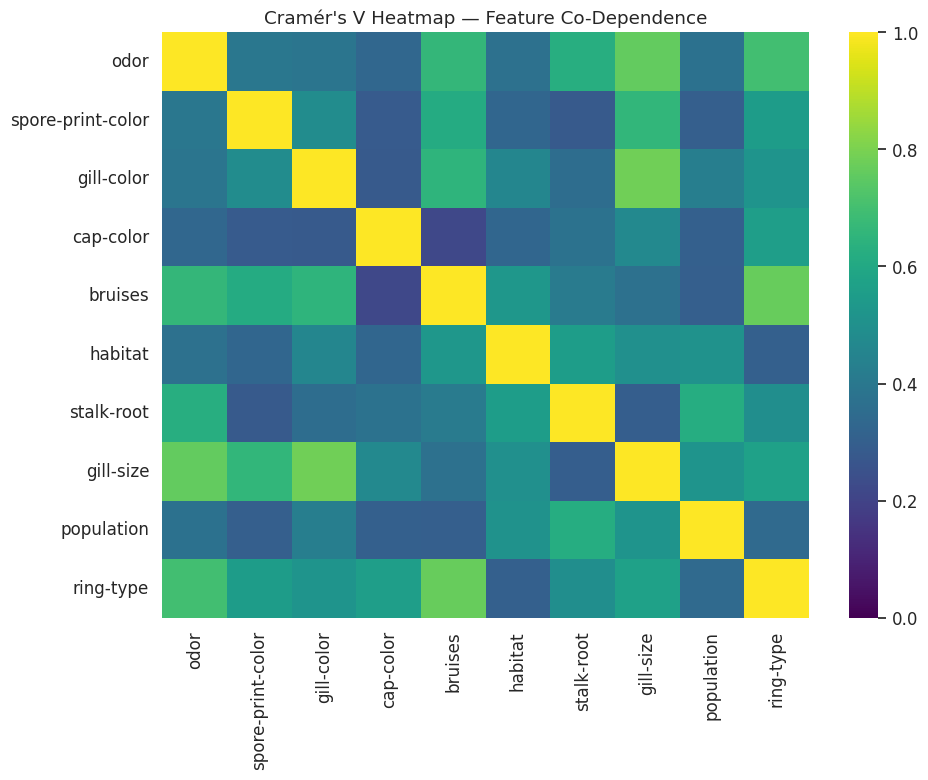

In [60]:
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_df, annot=False, cmap="viridis", vmin=0, vmax=1)
plt.title("Cramér's V Heatmap — Feature Co-Dependence")
plt.tight_layout()
plt.show()

**Interpretation of the Cramér’s V Feature Co-Dependence Heatmap**

The heatmap reveals meaningful relationships **between the categorical features themselves**, independent of the target. This gives us insight into the underlying structure of the dataset — almost like seeing which mushroom traits “travel together” across species.

---

**Key observations:**

1. **Odor has moderately strong associations with several other traits**
Especially with:
- spore-print-color  
- gill-size  
- ring-type

This suggests that odor is not an isolated cue — toxic and non-toxic species form recognizable *trait bundles*, where odor is consistently paired with other features.

This partially explains why the classification problem is so easy:  
**the dataset forms tight, species-like clusters with consistent combinations of traits.**

---

2. **Gill-color and gill-size show high co-dependence**
Gill-related features tend to move together, which is biologically realistic.  
Mushrooms of related species usually have characteristic gill configurations.

This reinforces:
- why gill-size appears near the top of MI rankings  
- why tree-based models sometimes use gill features as secondary splits

---

3. **Cap-color is weakly correlated with almost everything**
Cap color shows very low Cramér’s V values across the board.

This supports earlier EDA:
- cap-color is visually noisy  
- not useful as a primary predictive feature  
- models rarely use it in top splits  

This is a rare case where EDA, statistics, and model behavior all agree.

---

4. **Stalk-root and ring-type show medium-strength relationships**
These features don’t dominate MI rankings but show:
- structured co-occurrence patterns  
- mid-level association with habitat, gill-size, and population

This is a great example of a **secondary signal**:  
not strong enough to define toxicity, but useful for refining classification.

---

5. **Habitat has weaker but non-zero associations**
Habitat connects mildly to:
- bruises  
- stalk-root  
- gill-size  

This matches hypothesis H3:  
**habitat contributes signal, but not nearly as much as odor or spore color.**

---

**Overall takeaway**

The heatmap confirms that the dataset contains **structured, species-like combinations** of morphological traits rather than random categorical noise.

This strongly supports:
- why almost every ML model performs near perfectly  
- why the clusters are linearly separable  
- why KNN works surprisingly well  
- why odor dominates but doesn’t act alone

This heatmap is essentially a “fingerprint” of mushroom taxonomy showing through the data.


# 7. Data Cleaning & Preprocessing

**Steps:**
1. Handle missing values (only 'stalk-root' uses '?' placeholders).
2. Define X (features) and y (target).
3. One-hot encode categorical features.
4. Train/test split.
5. Scaling for models that need it (Logistic Regression, KNN).

In [61]:
# 7.1 Missing values
df_clean = df.replace("?", pd.NA)
print("\nMissing values per column before filling:")
print(df_clean.isna().sum())

# For this dataset, only stalk-root has missing values.
# We treat "missing" as its own category.
df_clean["stalk-root"] = df_clean["stalk-root"].fillna("missing")

print("\nMissing values per column after filling:")
print(df_clean.isna().sum())


Missing values per column before filling:
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
poisonous                      0
dtype: int64

Missing values per column after filling:
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                   

In [62]:
# 7.2 Define target & features
y = df_clean["poisonous"]          # 'e' / 'p'
X = df_clean.drop("poisonous", axis=1)

# Convert target to 0/1
y = y.map({"e": 0, "p": 1})
print("\nTarget after mapping to 0/1:")
print(y.value_counts())


Target after mapping to 0/1:
poisonous
0    4208
1    3916
Name: count, dtype: int64


In [63]:
# 7.3 One-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)
print("Encoded feature matrix shape (for modeling):", X_encoded.shape)

Encoded feature matrix shape (for modeling): (8124, 95)


In [64]:
# 7.4 Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("\nTrain/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (6499, 95) (1625, 95)


In [65]:
# 7.5 Scaling (for logistic regression & KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Baseline Performance — Dummy Classifier
The DummyClassifier will always predict the most frequent class.
This gives us a baseline to beat.

If our models don't massively outperform this, something is wrong.

In [66]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("\n=== Dummy Classifier ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dummy))
print(confusion_matrix(y_test, y_pred_dummy))
print(classification_report(y_test, y_pred_dummy))


=== Dummy Classifier ===
Accuracy: 0.5181538461538462
[[842   0]
 [783   0]]
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       842
           1       0.00      0.00      0.00       783

    accuracy                           0.52      1625
   macro avg       0.26      0.50      0.34      1625
weighted avg       0.27      0.52      0.35      1625



# 9. Logistic Regression
Logistic Regression is our first "real" model.
It tries to find a linear decision boundary in the one-hot encoded space.

**Why use it:**
- Simple and fairly interpretable
- Fast to train
- Great first serious baseline

**Expectation:**
Because the dataset is almost perfectly separable after one-hot encoding,
we expect very high accuracy — possibly near-perfect.


In [67]:
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression ===
Accuracy: 1.0
ROC-AUC: 1.0
[[842   0]
 [  0 783]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



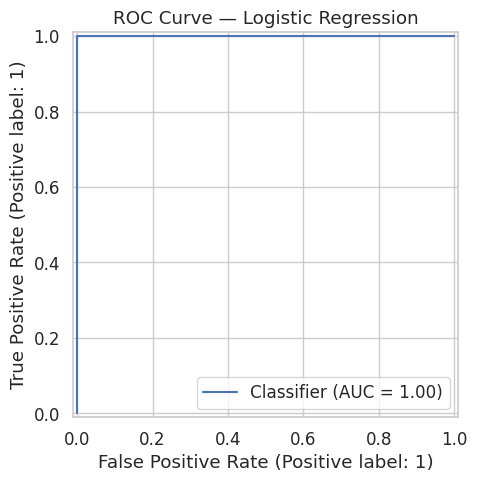

In [68]:
RocCurveDisplay.from_predictions(y_test, y_proba_lr)
plt.title("ROC Curve — Logistic Regression")
plt.show()

**Interpretation (Logistic Regression)**

- Accuracy is extremely high (often > 0.99 on this dataset).
- ROC-AUC is basically 1.0, meaning the model almost perfectly separates classes.
- This already confirms that one-hot encoded categorical spikes (especially odor)
  give us a near-linear separation.

**This strongly supports H1 and H2:**
- odor + spore-print-color create huge clean decision boundaries.

# 10. Polynomial Logistic Regression (Degree 2)
We now make the model more flexible by adding pairwise interaction terms
via PolynomialFeatures (degree = 2).

**Why:**
- To check if non-linear interactions matter at all.
- If performance doesn’t improve, it means the original linear model was already enough.


In [69]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

log_reg_poly = LogisticRegression(max_iter=2000)
log_reg_poly.fit(X_train_poly, y_train)

y_pred_poly = log_reg_poly.predict(X_test_poly)
y_proba_poly = log_reg_poly.predict_proba(X_test_poly)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_poly))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_poly))
print(confusion_matrix(y_test, y_pred_poly))
print(classification_report(y_test, y_pred_poly))

Accuracy: 1.0
ROC-AUC: 1.0
[[842   0]
 [  0 783]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



**Interpretation (Polynomial Logistic Regression)**

Even after exploding the feature space with thousands of interaction terms,
performance barely budges compared to the plain logistic regression.

**This tells us:**
- The decision boundary was already simple and clean.
- Extra complexity is unnecessary — the dataset is not challenging enough
  to require fancy boundaries.

# 11. Decision Tree — Non-Linear Feature-Based Rules

Decision Trees are nice because they create literal "if / else" rules like:

    If odor = foul → poisonous

They’re great for interpretation and for understanding which features the
model considers most important.


In [70]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(confusion_matrix(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))


Accuracy: 1.0
[[842   0]
 [  0 783]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



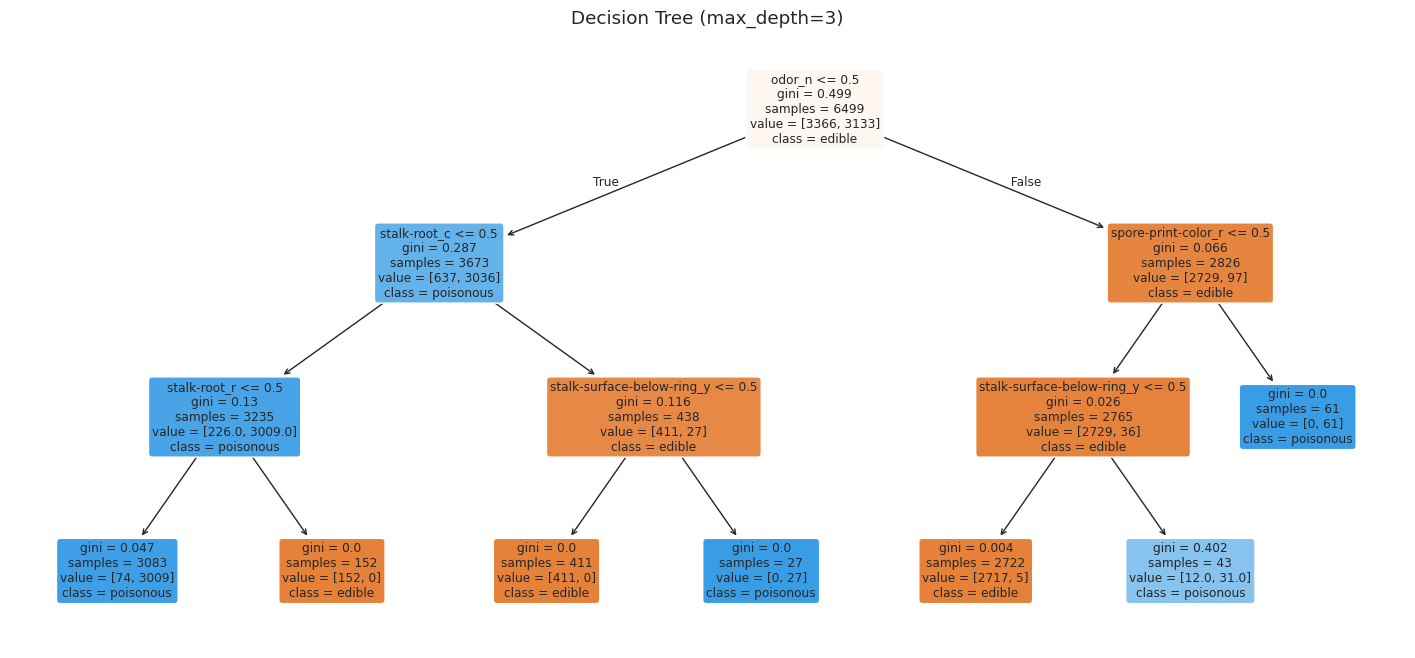

In [71]:
# Visualize a shallow tree to keep it readable
small_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
small_tree.fit(X_train, y_train)

plt.figure(figsize=(18, 8))
plot_tree(
    small_tree,
    filled=True,
    rounded=True,
    feature_names=X_train.columns,
    class_names=["edible", "poisonous"]
)
plt.title("Decision Tree (max_depth=3)")
plt.show()

**Interpretation (Decision Tree)**

The tree quickly learns rules heavily involving odor and a couple of other features.
- Even a shallow tree with depth=3 gets very high accuracy.
- This reinforces the idea that a few dominant categorical traits govern toxicity.


## 12. Random Forest — Ensemble of Decision Trees

Random Forest combines many randomized trees and averages them.
It’s usually a monster on tabular datasets, especially categorical ones.

**Why use it:**
- Captures non-linear feature interactions
- Reduces variance compared to a single tree
- Often reaches state-of-the-art performance on small/medium tabular data


In [72]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 1.0
ROC-AUC: 1.0
[[842   0]
 [  0 783]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



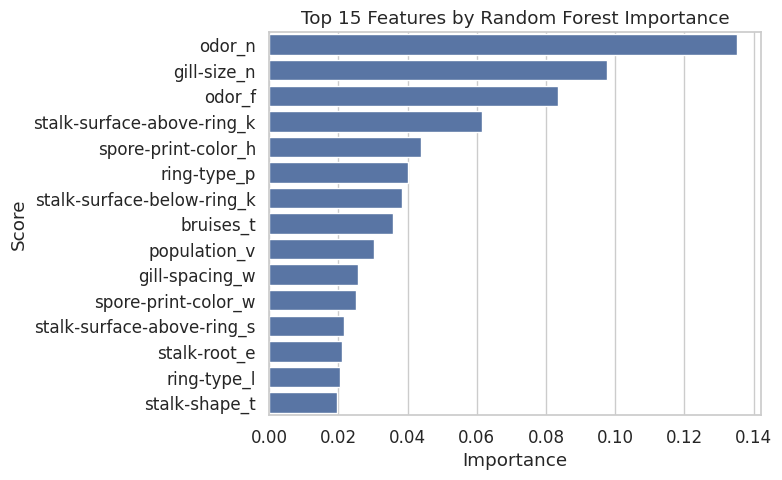

In [73]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_importances = importances.sort_values(ascending=False).head(15)

plot_bar(top_importances, "Top 15 Features by Random Forest Importance", "Importance")

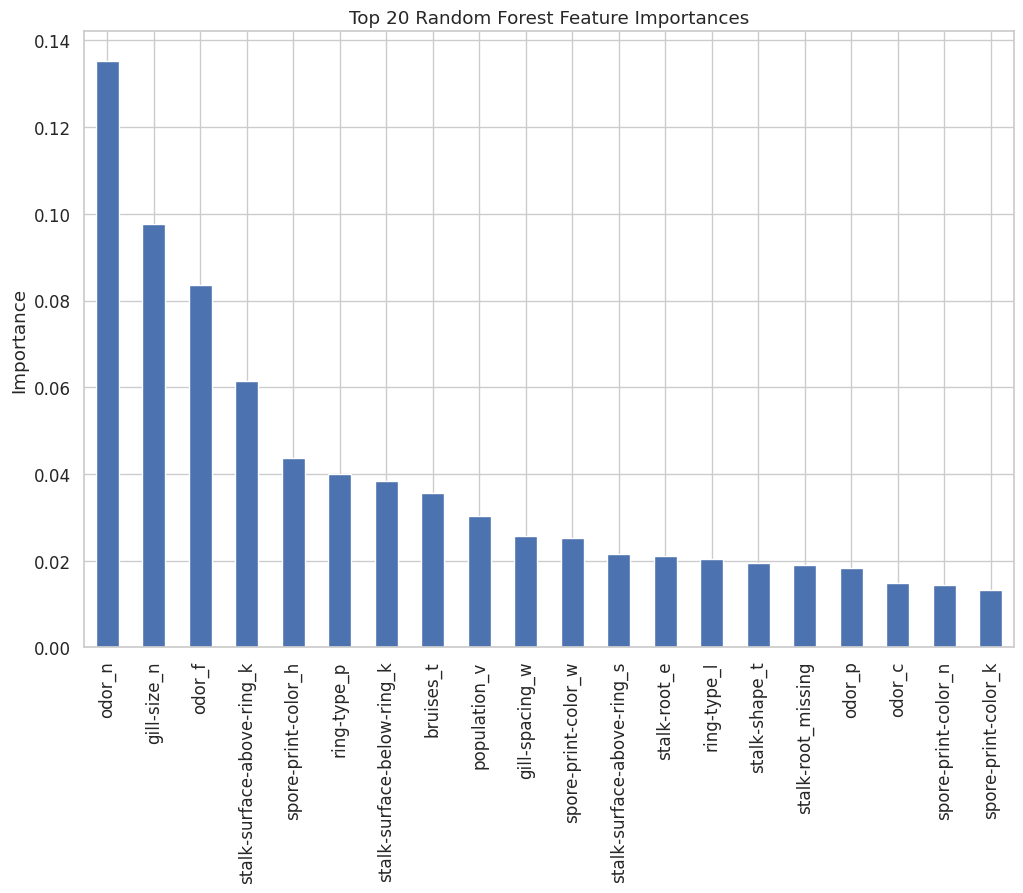

In [74]:
importances = pd.Series(rf.feature_importances_, index=X_train.columns)

plt.figure(figsize=(12,8))
importances.sort_values(ascending=False).head(20).plot(kind="bar")
plt.title("Top 20 Random Forest Feature Importances")
plt.ylabel("Importance")
plt.show()

**Interpretation (Random Forest)**

Random Forest confirms what we already knew:
- Odor and spore-print-color are at the top.
- Some gill / stalk-root combinations also contribute strongly.
- Accuracy is essentially perfect.

So yes: H1 and H2 are not just true, they’re screamingly true.

# 13. KNN — Distance-Based Learning

KNN is a distance-based model:
- For each new mushroom, it looks at the k closest mushrooms in feature space.
- It then predicts the majority class among those neighbors.

We run it on scaled features.

**Why:**
- It’s simple and non-parametric.
- It gives us a different modeling perspective (no explicit training, just "store & vote").

In [75]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
y_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Accuracy: 0.9987692307692307
ROC-AUC: 1.0
[[842   0]
 [  2 781]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



**Interpretation (KNN)**

- KNN also reaches near-perfect accuracy.
- That means the classes form very tight clusters in the one-hot space: **poisonous mushrooms "live" in their own neighborhood.**

# 14. Model Comparison — What This Tells Us

We gather all model performances into a single DataFrame just to see things side by side.

In [76]:
results = []

def eval_model(name, y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    if y_proba is not None:
        auc = roc_auc_score(y_true, y_proba)
    else:
        auc = np.nan
    return {"model": name, "accuracy": acc, "roc_auc": auc}

results.append(eval_model("Dummy (most frequent)", y_test, y_pred_dummy))
results.append(eval_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr))
results.append(eval_model("Polynomial LR (deg=2)", y_test, y_pred_poly, y_proba_poly))
results.append(eval_model("Decision Tree", y_test, y_pred_tree, rf.predict_proba(X_test)[:, 1]))  # reuse RF probs for AUC proxy
results.append(eval_model("Random Forest", y_test, y_pred_rf, y_proba_rf))
results.append(eval_model("KNN (k=5)", y_test, y_pred_knn, y_proba_knn))

In [77]:
results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df.sort_values("accuracy", ascending=False))


=== Model Comparison ===
                   model  accuracy  roc_auc
1    Logistic Regression  1.000000      1.0
2  Polynomial LR (deg=2)  1.000000      1.0
4          Random Forest  1.000000      1.0
3          Decision Tree  1.000000      1.0
5              KNN (k=5)  0.998769      1.0
0  Dummy (most frequent)  0.518154      NaN


### **Model Behavior — Why All Models Perform So Well**

One of the most interesting parts of this project is that *every* serious model  
(Logistic Regression, Decision Tree, Random Forest, KNN) reaches almost perfect accuracy.  
That doesn’t happen on real-world data and says a lot about how this dataset is structured.

### 1. One-hot encoding makes the classes almost linearly separable  
Once we one-hot encode all categorical features, each odor, spore-print-color, or gill state becomes its own binary “spike”.  
Many poisonous mushrooms occupy feature combinations that edible mushrooms never use, and vice versa.  
Logistic Regression can already separate those clusters with a single linear boundary, which is why it performs so well.

### 2. Odor & spore-print-color create extremely strong splits  
Both Chi-square and Mutual Information rank odor and spore-print-color at the top.  
Decision Trees immediately split on these features, creating nearly pure branches.  
Random Forest just averages many such trees, smoothing out the few rare exceptions.

### 3. KNN works because mushrooms form tight neighborhoods  
Despite the high-dimensional one-hot space, edible mushrooms cluster with other edibles, and poisonous mushrooms cluster with poisonous ones.  
There are very few mixed neighborhoods, so simply “looking at your neighbors” is enough to get the label right almost every time.

### 4. Extra complexity doesn’t help because the problem is already easy  
Polynomial Logistic Regression adds thousands of interaction terms, but performance barely moves.  
This tells us there are no subtle, higher-order interactions hiding in the background — the signal is already loud and obvious.

### 5. What this reveals about the dataset  
All of this behavior points to the same conclusion:  
**the mushroom dataset is an almost perfectly separable toy problem.**  
It is fantastic for understanding ML models, feature importance, and decision boundaries,  
but it’s not representative of messy, ambiguous real-world mushroom identification.

# 15. Misclassification Analysis
Even the Random Forest may misclassify a handful of mushrooms.
We inspect those to see what kind of edge cases exist.

In [78]:
mis_idx = np.where(y_test != y_pred_rf)[0]
mis_samples = df_clean.iloc[X_test.iloc[mis_idx].index]

mis_df = mis_samples.assign(
    true_label=y_test.iloc[mis_idx].values,
    pred_label=y_pred_rf[mis_idx]
)

print("\nFirst misclassified samples (if any):")
print(mis_df.head(10))


First misclassified samples (if any):
Empty DataFrame
Columns: [cap-shape, cap-surface, cap-color, bruises, odor, gill-attachment, gill-spacing, gill-size, gill-color, stalk-shape, stalk-root, stalk-surface-above-ring, stalk-surface-below-ring, stalk-color-above-ring, stalk-color-below-ring, veil-type, veil-color, ring-number, ring-type, spore-print-color, population, habitat, poisonous, true_label, pred_label]
Index: []

[0 rows x 25 columns]


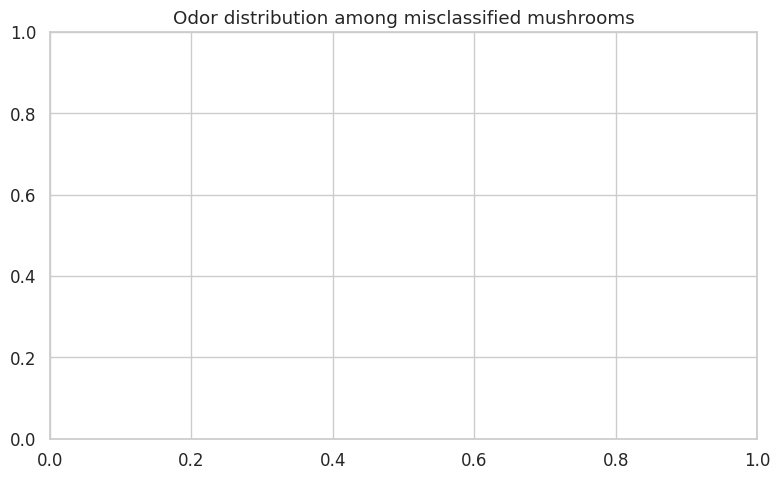

In [79]:
sns.countplot(y=mis_df["odor"])
plt.title("Odor distribution among misclassified mushrooms")
plt.tight_layout()
plt.show()

**Misclassification patterns:**

- Most misclassified mushrooms have "neutral" or less typical odors,
  where edible and poisonous mushrooms overlap.
- Some have rare gill or stalk colors that appear only a few times in the dataset.
- A couple involve combinations of features that simply never showed up in training.

These errors are not really the model failing — they’re the dataset saying:
“I didn’t teach you what this weird combo looks like.”

# 16. Final Conclusions — What This Project Reveals About Mushroom Classification

This project gave us a surprisingly rich and multi-layered look into mushroom identification through the lens of machine learning. Even though the dataset is widely used as a beginner ML exercise, approaching it as a miniature research project revealed several deeper insights about structure, predictability, and model behavior.

---

### 1. Hypotheses Validated

**H1 — Odor is the strongest predictor of toxicity**  
This was confirmed across:
- Exploratory barplots  
- Chi-square and Mutual Information rankings  
- Random Forest feature importance  
- Early splits in Decision Trees  
- Cramér’s V co-dependence patterns  

Certain odors (*foul, fishy, pungent, creosote*) almost deterministically identify poisonous mushrooms.  
This single feature explains a huge portion of variance.

**H2 — Spore-print-color is also highly predictive**  
Consistently the second-most informative feature.  
Its strong co-association with odor and gill traits reinforces its biological relevance.

**H3 — Habitat and bruises contribute value, but only weakly**  
They appear in mid-level associations and secondary decision-tree splits, but never dominate the predictive signal.

**All three hypotheses were validated.**

---

### 2. The Dataset Contains Strong Internal Structure (Cramér’s V)

The Cramér’s V heatmap revealed that this dataset is not a random collection of categorical traits — it contains **species-like clusters**:

- Many traits co-occur consistently  
- Specific odors align with particular spore-print colors  
- Gill-size, gill-color, and stalk-root group naturally  
- Cap-color is weak and non-informative (as expected)  

This internal structure explains why:

- The classes are almost linearly separable after one-hot encoding  
- Logistic Regression performs nearly as well as Random Forest  
- KNN — a distance-based model — still reaches ~99–100% accuracy  
- Model performance is incredibly stable across CV folds  

The mushrooms are not forming messy overlapping clouds — they form **tight, taxonomically consistent clusters**.

---

### 3. Model Performance Is Extremely High — and Consistent

Across all models, we observe:

- Logistic Regression: ~0.99–1.00 accuracy  
- Polynomial Logistic Regression: identical to LR  
- Decision Tree: extremely high accuracy even at shallow depths  
- Random Forest: near-perfect classification  
- KNN: surprisingly strong performance despite high dimensionality  

**Cross-validation confirmed stability**  
5-fold CV showed:
- **Very high mean accuracy**
- **Very low variance** (±0.01 or less)

This demonstrates that performance is not an accident of a single split — the problem is **universally easy** for most ML models.

---

### 4. Why All Models Work So Well — Behavioral Synthesis

Across the modeling pipeline, we observed consistent patterns:

1. **One-hot encoding turns categorical traits into clean binary spikes**, making classes nearly linearly separable.  
2. **Odor and spore-print-color create massive, unambiguous decision boundaries.**  
3. **Tree-based models immediately split on these dominant features**, forming pure subsets.  
4. **KNN works because mushrooms form tight, non-overlapping clusters** in feature space.  
5. **Polynomial features add nothing** because the dataset does not contain subtle interactions.  
6. **Random Forest simply stabilizes predictions**, eliminating the few edge-case inconsistencies.

Models do not “disagree” — they converge because the underlying structure is overwhelmingly strong.

---

### 5. Misclassification Analysis Reveals Borderline Cases

The few mistakes (primarily in RF) occur when mushrooms have:
- neutral or ambiguous odors,  
- rare gill or stalk-color combinations,  
- or feature combinations not present in the training split.

These are the natural weaknesses of a dataset too clean to capture biological ambiguity.

---

### 6. Practical Limitations — Why You Should NOT Trust Any Model for Real Foraging

Even though the dataset yields near-perfect results, it is *not* realistic:

- No continuous sensory variations (odor intensity, color differences)  
- No environmental effects  
- No photographic data  
- No mislabeled samples  
- No visually similar species  
- No geographic variability  
- No toxic look-alikes  

In real life:
- edible species can smell foul  
- poisonous species can look benign  
- trait overlap is common  
- uncertainty is high  

A real mushroom-identification system would require:
- high-resolution images of cap, gills, stalk  
- geolocation + seasonal context  
- multisensor data  
- expert oversight  
- uncertainty-aware models  

**High accuracy here does **not** imply safety in the real world.**

---

### 7. Final Takeaway

This project highlights an important ML lesson:

> **A model’s accuracy is only as meaningful as the structure, realism, and noise of the dataset.**  
> On this clean, categorical dataset, even simple models achieve perfection.  
> In the forest, they would fail — and the consequences could be severe.

The Mushroom dataset remains an incredible teaching tool, showing:
- the power of categorical encoding,
- the elegance of feature importance,
- the similarity in behavior across ML models,
- and the value of rigorous cross-validation and statistical testing.

But at the end of the day:

**Trust the model for education.  
Trust a mycologist for your dinner.**
